In [ ]:
#필요 모듈 import
from google.colab import drive
drive.mount('/content/drive')
import io
import os
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 전처리

1. 임의로 분류한 폴더 내의 파일 제목을 읽어 리스트로 만듭니다.(study_data, test_data)

In [ ]:
#임의로 나눈 파일 디렉토리 읽어서 각 csv 파일 제목 저장
study_file=os.listdir('/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/study_data')
print(study_file)
test_file = os.listdir('/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/test_data')
print(test_file)

['abortion_counts.csv', 'blm_movement_counts.csv', 'islam_counts.csv', 'espionage_counts.csv', 'human_rights_counts.csv', 'china_counts.csv', 'judaism_counts.csv', 'military_spending_counts.csv', 'guns_counts.csv', 'sexual_harrassment_counts.csv', 'oil_counts.csv', 'russia_counts.csv', 'native_americans_counts.csv', 'palestine_counts.csv', 'tech_censorship_counts.csv', 'universities_counts.csv']
['affirmative_action_counts.csv', 'israel_counts.csv', 'church_state_counts.csv', 'climate_change_counts.csv', 'cuba_counts.csv', 'prisons_counts.csv', 'public_finance_counts.csv', 'nuclear_weapons_counts.csv', 'police__counts.csv', 'private_finance_counts.csv', 'yemen_counts.csv', 'venezuela_counts.csv', 'us_immigration_counts.csv']


2. 파일 읽어오기  
 파일 제목 리스트(study_file, test_file)를 이용해 각 디렉토리에서 csv 파일을 읽어와 globals 함수를 이용해 저장합니다. 저장하며 column의 1열(total)을 삭제해줍니다. total은 데이터 처리에 상관없는 값이므로 전처리 과정에서 지우는 편이 효율적입니다.

In [ ]:
#study_data 파일 읽어오기
%cd /content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/study_data
for i in range(0, len(study_file)-1):
  globals()['study_data{}'.format(i)] = pd.read_csv(study_file[i], encoding='cp949', header=None)
  globals()['study_data{}'.format(i)] = globals()['study_data{}'.format(i)].drop(1, axis=1)
# print(globals()['study_data{}'.format(0)].head)

#test_data 파일 읽어오기
%cd /content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/test_data
for i in range(0, len(test_file)-1):
  globals()['test_data{}'.format(i)] = pd.read_csv(test_file[i], encoding='cp949', header=None)
  globals()['test_data{}'.format(i)] = globals()['test_data{}'.format(i)].drop(1, axis=1)

/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/study_data
/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/phrase_counts/test_data


여기서부터는 study_file의 전처리와 3차원 시각화, 정확도 산출을 진행합니다. test_file은 가설이 맞는지 확인할 때 사용해야 하므로 나중에 일괄적으로 처리 및 계산합니다.

3. 단어 리스트 만들기  
 study_data의 csv는 행의 index(column의 0열)가 단어입니다.  
globals 함수를 이용해 st_word라는 이름으로 각 데이터들의 단어 리스트를 저장합니다.
이렇게 저장한 상태에서 st_word의 0번째는 PHRASE이므로 전부 삭제해 줍니다.

4. 언론사 리스트 만들기  
  study_data의 csv의 row는 언론사입니다. 언론사도 globals 함수를 이용해 media_list라는 이름으로 각 언론사를 저장합니다.
 (각 데이터별로 언론사가 다른 경우가 발생할 수 있습니다.)

In [ ]:
#단어 리스트 
for i in range(0, len(study_file)-1):
  a = globals()['study_data{}'.format(i)][0]
  globals()['st_word{}'.format(i)] = a.values.tolist()
  del globals()['st_word{}'.format(i)][0]

# print(globals()['st_word{}'.format(0)])

#언론사 리스트
for i in range(0, len(study_file)-1):
  globals()['media_list{}'.format(i)] = globals()['study_data{}'.format(i)].iloc[0].tolist()
  del globals()['media_list{}'.format(i)][0]
# print(media_list0)
# print(len(media_list0))

#데이터 분석 및 마이닝

##3차원 시각화  
3차원 공간에 데이터를 표현하기 위한 준비를 합니다.   
3차원 공간의 각 축은 모두 같으며, i번째 데이터의 단어 리스트(앞서 생성한 st_word)입니다. (x=y=z=st_word{}.format(i))  
표시될 점은 언론사이고, 각각의 한 점은 각 데이터에서 추출한 3개의 가장 높은 노출수를 가진 단어들을 인스턴스로 가집니다. 3개의 인스턴스들은 x, y, z 축에 대응됩니다.  
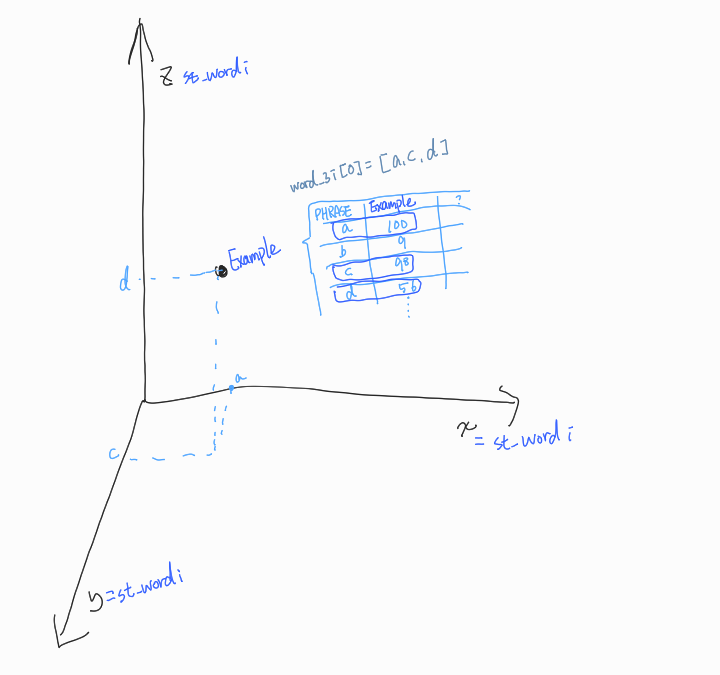

1. 각 언론사 별 노출수 높은 3개 단어 추출  
  1. 전처리  
 st_d라는 이름으로 study_data의 column과 row의 index를 지운 데이터프레임을 만듭니다. csv 상에서 완전히 숫자만 남은 모양이 됩니다.  
 정수 타입(int)으로 변환 후, columns와 rows를 각각 study_data에서의 columns와 rows로 붙여줍니다.

In [ ]:
#최대 단어 3개 뽑을때 사용할 csv 전처리(column, row 각각 언론사와 단어로 지정해 새로 만듬)
#런타임 내에서 다시 실행시 st_d 데이터 프레임 이상 생기므로 실행시 런타임 초기화 필요
for i in range(0, len(study_file)-1):
  globals()['st_d{}'.format(i)]=globals()['study_data{}'.format(i)].drop(0).drop(0,axis=1)
  globals()['st_d{}'.format(i)]=globals()['st_d{}'.format(i)].apply(pd.to_numeric)
  globals()['st_d{}'.format(i)].columns = globals()['study_data{}'.format(i)].iloc[0,1:]
  globals()['st_d{}'.format(i)].reset_index(drop=True)
  globals()['st_d{}'.format(i)]=globals()['st_d{}'.format(i)].set_index(globals()['study_data{}'.format(i)].iloc[1:,0])

# print(len(globals()['st_d{}'.format(0)]))
# globals()['st_d{}'.format(0)]


  2. nlargest 함수를 이용한 각 언론사 별 단어 리스트 만들기  
   데이터 프레임을 앞서 만든 st_d로 두고 nlargest 함수를 이용해 가장 높은 숫자들을 데이터프레임으로 형성합니다. 다음과 같은 형태의 데이터프레임이 형성됩니다.(실제 예시입니다.)


```
a = df.nlargest(3, globals()['media_list{}'.format(0)][0])
print(a)
```


|0|aljazeera|alternet|americanconservative|
|------|---|---|---|
|abrotion rights|97|42|15|
|pregnancy|61|69|8|
|anti abortion|53|54|4|
...

이때 정렬의 기준이 되는 것은 0번째 언론사인 aljazeera입니다. 따라서 A는 현재 a의 index인 ['abrotion rights', 'pregnancy', 'anti abortion']를 갖게 됩니다.  

for 문에 의해 i 숫자가 바뀌어 1이 되면 alternet을 기준으로 가장 높은 세개의 단어를 재정렬해 index를 추출합니다. word_3은 이제 [['abrotion rights', 'pregnancy', 'anti abortion'],['pregnancy', 'birth control', 'anti abortion']]이 됩니다. 이 과정을 study_file의 개수만큼 반복해 각 파일마다 모든 언론사의 가장 많이 노출된 세개의 단어를 얻습니다.  

딕셔너리가 아닌 리스트 형태로 word_3를 만든 이유는 media_list의 순서가 변하지 않고 키 값(이 경우에는 인덱스가 되는 숫자)이 동일하므로 리스트가 더 효율적일 수 있다고 판단했기 때문입니다.


In [ ]:
#각 파일-각 언론사 별 자주 사용하는 3개 단어(리스트로 저장)

for k in range(0, len(study_file)-1):
  globals()['word_3{}'.format(k)]=[]
  for i in range(0, len(globals()['media_list{}'.format(k)])-1):
    df = globals()['st_d{}'.format(k)]
    a = df.nlargest(3, globals()['media_list{}'.format(k)][i])  #가장 높은 값 가진 3개 숫자를 데이터 프레임으로 생성.
    A = a.index.to_list() #a(데이터프레임) index만 추출해 리스트로 변환.
    # print(A)
    globals()['word_3{}'.format(k)].append(A) #A에 있는 index 리스트 추가.

# print(len(globals()['word_3{}'.format(0)]))
# globals()['word_3{}'.format(0)]


3. 3차원 시각화  
  1. 단어 리스트 매핑  
   기반이 되는 단어 리스트는 전처리과정에서 만들었던 st_word를 사용합니다. 이를 기반으로 mapping이라는 이름으로 단어를 해당하는 인덱스에 매핑하는 매핑 딕셔너리를 생성합니다.  (line 3~5) 
  
     데이터를 mapping을 사용해 매핑된 데이터로 변환합니다.
  for문을 이용해 데이터의 각 점에 대해 반복합니다. 각 점의 좌표를 매핑 딕셔너리를 통해 정수형으로 변환한 후,(이때 각 점의 좌표는 앞서 만들었던 최빈 3개 단어입니다.) 그 점을 data_int 리스트에 추가합니다. (line 8~14)  

   2. 축 설정 및 산점도 그리기  
    3차원 공간의 축 설정 및 그래프 설정을 합니다.(line 16~34) 

    각 점의 x, y, z 좌표를 추출한 후, 그 좌표들을 통해 3차원 산점도를 그립니다.(line 36~40)
  
  3. 각 점의 레이블 설정  
  labels이라는 이름으로 media_list를 가져온 후, 레이블을 가져와 각 점에 대한 텍스트를 지정합니다. 이로써 언론사의 이름이 각 점에 대한 레이블로 표현됩니다.(line 42~25)  

  4. 파일 저장  
  filename으로 저장될 경로를 지정한 후, 3차원 그래프를 이미지 파일로 저장합니다.

In [ ]:
#3차원 시각화

for k in range(0, len(study_file)-1):
  data = globals()['word_3{}'.format(k)]
  mapping = {item: idx for idx, item in enumerate(globals()['st_word{}'.format(k)])}
  # print(mapping)

  mapped_data = [[mapping[val] for val in lst] for lst in data]
  # print(mapped_data)

  data_int = [] #정수형 데이터 저장용 
  for point in data:
      point_int = [mapping[label] for label in point]
      data_int.append(point_int)

  # 축 레이블 리스트
  axis_labels = list(mapping.keys())

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')

  # 축 범위 지정
  ax.set_xlim(0, len(mapping) - 1)
  ax.set_ylim(0, len(mapping) - 1)
  ax.set_zlim(0, len(mapping) - 1)


  # 축 레이블 지정
  ax.set_xticks(range(len(axis_labels)))
  ax.set_yticks(range(len(axis_labels)))
  ax.set_zticks(range(len(axis_labels)))
  ax.set_xticklabels(axis_labels, fontsize=4, rotation=90)
  ax.set_yticklabels(axis_labels, fontsize=4, rotation=0)
  ax.set_zticklabels(axis_labels, fontsize=4, rotation=0)

  # 데이터 플롯
  x = [point[0] for point in data_int]
  y = [point[1] for point in data_int]
  z = [point[2] for point in data_int]
  ax.scatter(x, y, z)

  labels = globals()['media_list{}'.format(k)]

  for i, label in enumerate(labels[:len(data_int)]):
      ax.text(x[i], y[i], z[i], label, fontsize=6)
      
  filename=f'/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/study_image/image_{k}.png'
  plt.savefig(filename, dpi=300)
  # plt.show()
  

Output hidden; open in https://colab.research.google.com to view.

4. 거리 계산 데이터베이스 생성  
앞서 생성한 3차원 그래픽을 토대로 두 점의 거리를 계산해 데이터 프레임을 생성하고, 이를 파일로 저장합니다.
  1. 경로 설정  
  코드 실행 위치를 재설정합니다.  
  2. 거리 계산  
  study_file의 데이터베이스 개수만큼 for문을 통해 실행합니다. word_3와 st_word를 활용해 데이터와 매핑 정보를 가져옵니다. media_list에서 데이터프레임의 행과 열 인덱스를 설정합니다. 이를 통해 데이터를 매핑된 형태로 변환합니다.  
  3차원 거리 계산법(유클리디안 거리 계산법)을 통해 계산된 두 점 사이의 거리를 distances에 저장합니다.  
  계산한 거리를 저장할 새 데이터 프레임 df를 생성합니다. for문을 통해 비교하는 두 점이 같은 위치일때는 np.nan(결측치)를 할당하고, 서로 다른 두 점일 시에는 distances에서 해당 위치에 있는 거리 값을 가져와 할당합니다.  
  3. 데이터프레임 저장  
  for문을 통해 df에 거리 값을 저장합니다. globals 함수를 통해 df를 저장합니다. file_name으로 설정된 경로에 데이터 프레임을 .csv 형식으로 저장합니다. 

In [ ]:
#저장을 위한 경로 변경
%cd /content/drive/MyDrive/Colab Notebooks/3113_data_analyze/study_distance/

#거리 계산 데이터프레임 csv 저장
for k in range(0, len(study_file)-1):

  data = globals()['word_3{}'.format(k)]
  mapping = {item: idx for idx, item in enumerate(globals()['st_word{}'.format(k)])}
  media_list = globals()['media_list{}'.format(k)]
  print(mapping)

  # 새로운 데이터프레임 행, 열 인덱스 지정
  columns = media_list
  index = media_list

  mapped_data = [[mapping[val] for val in lst] for lst in data]

  data_int = []
  for point in data:
      point_int = [mapping[label] for label in point]
      data_int.append(point_int)

  distances = []
  for i, pair in enumerate(itertools.combinations(data_int, 2)):
      x1, y1, z1 = pair[0]
      x2, y2, z2 = pair[1]
      distance = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)**0.5
      distances.append(distance)

  df = pd.DataFrame(columns=columns, index=index)
  for i in range(len(media_list)):
      for j in range(len(media_list)):
          if i == j:
              df.iloc[i, j] = np.nan
          elif i > j:
              idx = 3*(j-1) - (j-1)*(j-2)//2 + (i-j-1)
              df.iloc[i, j] = distances[idx]
          else:
              idx = 3*(i-1) - (i-1)*(i-2)//2 + (j-i-1)
              df.iloc[i, j] = distances[idx]

  # display(df)
  globals()['distance{}'.format(k)]=df
  file_name = study_file[k] + 'distance.csv'
  df.to_csv(file_name, index=True)
  # print(f"{file_name} 파일이 저장되었습니다.")


/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/study_distance
{'pro life': 0, 'abortion rights': 1, 'anti abortion': 2, 'anti choice': 3, 'abortion care': 4, 'pregnancy': 5, 'kill': 6, 'medical abortion': 7, 'family planning': 8, 'pro abortion': 9, 'murder': 10, 'fetus': 11, 'mother': 12, 'reproductive rights': 13, 'infanticide': 14, 'abortion access': 15, 'abortion ban': 16, 'infant': 17, 'reproductive health': 18, 'pro choice': 19, 'abortion law': 20, 'medication abortion': 21, 'contraception': 22, 'fetal heartbeat': 23, 'fetal remains': 24, 'abortion services': 25, 'born alive': 26, 'birth control': 27, 'religious liberty': 28, 'aborted': 29, 'abortion rules': 30, 'abortion providers': 31, 'reproductive justice': 32, 'womens rights': 33, 'dead': 34, 'termination': 35, 'abortion clinic': 36, 'adoption': 37, 'rape or incest': 38, 'maternal': 39, 'abortion restrictions': 40, 'abortion pills': 41, 'unborn babies': 42, 'abortionists': 43, 'fetal abnormalities': 44, 'human life'

5. 평균 거리 계산  
  1. 경로 설정  
    파일 저장을 위해 경로를 재설정합니다.
  2. 새로운 데이터프레임 생성  
  mean_df라는 이름으로 평균 거리를 저장할 데이터프레임을 생성합니다. 행과 열은 이전에 정의한 columns와 index를 사용합니다.  
  3. 평균값 계산  
  이중 for문을 통해 mean_df의 각 셀에 평균 거리 값을 계산해 할당합니다. 반복문에서는 각 distance의 (i, j)위치 값들을 가져와 생성과 초기화를 한 values 리스트에 저장합니다. pd.notnull 함수를 통해 결측치가 아니라면 values에 추가합니다. 그리고 values 리스트의 평균값을 계산해 mean_values에 저장합니다. values 리스트에서 빈 셀은 결산치를 할당합니다. mean_df의 (i,j) 위치에 평균값을 할당합니다.  
  4. 데이터프레임 저장  
  mean_df를 csv파일로 저장합니다.

In [40]:
#거리 계산 데이터 프레임 통한 정확도 산출
%cd /content/drive/MyDrive/Colab Notebooks/3113_data_analyze
# 데이터프레임의 개수
num_frames = len(study_file) - 1

# 새로운 데이터프레임 생성
mean_df = pd.DataFrame(index=index, columns=columns)

# 각 위치의 평균값 계산
for i in range(len(media_list)):
    for j in range(len(media_list)):
        values = []
        for k in range(num_frames):
            try:
                value = globals()['distance{}'.format(k)].iloc[i, j]
                if pd.notnull(value):
                    values.append(value)
            except (IndexError, KeyError):
                continue
        mean_value = np.mean(values) if values else np.nan
        mean_df.iloc[i, j] = mean_value

# 새로운 데이터프레임 저장
mean_df.to_csv('mean_distance.csv', index=True)
print("평균 거리 데이터프레임이 저장되었습니다.")

/content/drive/MyDrive/Colab Notebooks/3113_data_analyze
평균 거리 데이터프레임이 저장되었습니다.


6. 유사도 계산  
  1. 유사도 계산 함수  
  평균 거리 데이터 프레임 mean_df와 최대 거리 값 max_distance를 입력으로 받아, 정확도를 계산합니다. 같은 위치일때 정확도가 100이고, 가장 먼 거리일때 0이 됩니다.  
  데이터 프레임 accuracy_df에 값을 할당하고, 결측치는 0으로 할당합니다.  
  2. 경로 설정  
  3. 최대 거리 계산  
  mean_df에서 가장 먼 거리를 max_distance로 지정합니다.
  4. 정확도 계산  
  최대 거리와 정확도 함수를 기준으로 정확도를 계산합니다.
  5. 파일 저장  
  accuracy_file을 csv 파일로 저장합니다.


In [29]:
# 유사도 계산 함수
def calculate_accuracy(mean_df, max_distance):
    accuracy_df = 100 * (1 - (mean_df / max_distance))
    accuracy_df = accuracy_df.fillna(100)  # NaN 값을 100으로 채워줍니다.
    return accuracy_df

# 저장 경로 설정
%cd /content/drive/MyDrive/Colab Notebooks/3113_data_analyze/similar_study/

# 데이터프레임 저장
for k in range(0, len(study_file)-1):
    mean_df = globals()['distance{}'.format(k)]

    # 최대 거리 계산
    max_distance = np.max(mean_df.values)  # 평균 거리 데이터프레임에서 가장 큰 값이 최대 거리입니다.

    # 정확도 계산
    accuracy_df = calculate_accuracy(mean_df, max_distance)

    # 파일 저장
    accuracy_file = study_file[k]
    globals()['accuracy{}'.format(k)]=accuracy_df
    accuracy_df.to_csv(accuracy_file, index=True)
    print(f"{accuracy_file} 파일이 저장되었습니다.")


/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/similar_study
abortion_counts.csv 파일이 저장되었습니다.
blm_movement_counts.csv 파일이 저장되었습니다.
islam_counts.csv 파일이 저장되었습니다.
espionage_counts.csv 파일이 저장되었습니다.
human_rights_counts.csv 파일이 저장되었습니다.
china_counts.csv 파일이 저장되었습니다.
judaism_counts.csv 파일이 저장되었습니다.
military_spending_counts.csv 파일이 저장되었습니다.
guns_counts.csv 파일이 저장되었습니다.
sexual_harrassment_counts.csv 파일이 저장되었습니다.
oil_counts.csv 파일이 저장되었습니다.
russia_counts.csv 파일이 저장되었습니다.
native_americans_counts.csv 파일이 저장되었습니다.
palestine_counts.csv 파일이 저장되었습니다.
tech_censorship_counts.csv 파일이 저장되었습니다.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
#단어 리스트 
for i in range(0, len(test_file)-1):
  a = globals()['test_data{}'.format(i)][0]
  globals()['t_word{}'.format(i)] = a.values.tolist()
  del globals()['t_word{}'.format(i)][0]

# print(globals()['st_word{}'.format(0)])

#언론사 리스트
for i in range(0, len(test_file)-1):
  globals()['test_media_list{}'.format(i)] = globals()['test_data{}'.format(i)].iloc[0].tolist()
  del globals()['test_media_list{}'.format(i)][0]
# print(media_list0)
# print(len(media_list0))

In [ ]:
for i in range(0, len(test_file)-1):
  globals()['t_d{}'.format(i)]=globals()['test_data{}'.format(i)].drop(0).drop(0,axis=1)
  globals()['t_d{}'.format(i)]=globals()['t_d{}'.format(i)].apply(pd.to_numeric)
  globals()['t_d{}'.format(i)].columns = globals()['test_data{}'.format(i)].iloc[0,1:]
  globals()['t_d{}'.format(i)].reset_index(drop=True)
  globals()['t_d{}'.format(i)]=globals()['t_d{}'.format(i)].set_index(globals()['test_data{}'.format(i)].iloc[1:,0])

for k in range(0, len(test_file)-1):
  globals()['test_3{}'.format(k)]=[]
  for i in range(0, len(globals()['test_media_list{}'.format(k)])-1):
    df = globals()['t_d{}'.format(k)]
    a = df.nlargest(3, globals()['test_media_list{}'.format(k)][i])  #가장 높은 값 가진 3개 숫자를 데이터 프레임으로 생성.
    A = a.index.to_list() #a(데이터프레임) index만 추출해 리스트로 변환.
    # print(A)
    globals()['test_3{}'.format(k)].append(A) #A에 있는 index 리스트 추가.

In [15]:
#저장을 위한 경로 변경
%cd /content/drive/MyDrive/Colab Notebooks/3113_data_analyze/test_distance/

#거리 계산 데이터프레임 csv 저장
for k in range(0, len(test_file)-1):

  data = globals()['test_3{}'.format(k)]
  mapping = {item: idx for idx, item in enumerate(globals()['t_word{}'.format(k)])}
  media_list = globals()['test_media_list{}'.format(k)]
  print(mapping)

  # 새로운 데이터프레임 행, 열 인덱스 지정
  columns = media_list
  index = media_list

  mapped_data = [[mapping[val] for val in lst] for lst in data]

  data_int = []
  for point in data:
      point_int = [mapping[label] for label in point]
      data_int.append(point_int)

  distances = []
  for i, pair in enumerate(itertools.combinations(data_int, 2)):
      x1, y1, z1 = pair[0]
      x2, y2, z2 = pair[1]
      distance = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)**0.5
      distances.append(distance)

  df = pd.DataFrame(columns=columns, index=index)
  for i in range(len(media_list)):
      for j in range(len(media_list)):
          if i == j:
              df.iloc[i, j] = np.nan
          elif i > j:
              idx = 3*(j-1) - (j-1)*(j-2)//2 + (i-j-1)
              df.iloc[i, j] = distances[idx]
          else:
              idx = 3*(i-1) - (i-1)*(i-2)//2 + (j-i-1)
              df.iloc[i, j] = distances[idx]

  # display(df)
  globals()['t_distance{}'.format(k)]=df
  file_name = study_file[k] + 't_distance.csv'
  df.to_csv(file_name, index=True)
  # print(f"{file_name} 파일이 저장되었습니다.")


/content/drive/MyDrive/Colab Notebooks/3113_data_analyze/test_distance
{'affirmative action': 0, 'racial preferences': 1, 'admissions decisions': 2, 'privilege': 3, 'race based': 4, 'consider race': 5, 'quotas': 6, 'consideration of race': 7, 'racial minorities': 8, 'race into account': 9, 'admissions process': 10, 'admissions policies': 11, 'holistic': 12, 'preferential treatment': 13, 'race conscious admissions': 14, 'take race into': 15, 'use of race': 16, 'race neutral': 17, 'race relations': 18, 'overrepresented': 19, 'racial diversity': 20, 'racial discrimination': 21, 'underrepresented groups': 22, 'disparities': 23, 'racial balance': 24, 'equal protection': 25}
{'annexation': 0, 'anti Israel': 1, 'anti Semitic': 2, 'anti Semitism': 3, 'genocide': 4, 'Benjamin Netanyahu': 5, 'peace': 6, 'reparations': 7, 'sanctions': 8, 'settlements': 9, 'solidarity': 10, 'sovereignty': 11, 'terrorist': 12, 'the Middle East': 13, 'the Palestinian': 14, 'violence': 15, 'war': 16, 'colonial': 17, 

In [43]:
# 테스트 데이터 전처리
test_data = []  # 테스트 데이터 저장할 리스트
for i in range(len(test_file) - 1):
    a = globals()['test_data{}'.format(i)][0]
    t_word = a.values.tolist()
    del t_word[0]
    test_data.append(t_word)

test_distances = []  # 테스트 데이터의 거리 계산 결과를 저장할 리스트

# 유사도 계산 및 비교
total_difference = 0
total_count = 0

for k in range(len(test_file) - 1):
    test_df = pd.DataFrame(globals()['test_data{}'.format(k)], columns=media_list)
    test_df = test_df.astype(float)

    test_data = test_df.values.tolist()

    distances = []
    for i in range(len(test_data)):
        max_distance = 0
        for j in range(i + 1, len(test_data)):  # j의 범위를 i+1부터 시작하도록 수정
            point1 = test_data[i]
            point2 = test_data[j]
            distance = ((point1[0] - point2[0]) ** 2 +
                        (point1[1] - point2[1]) ** 2 +
                        (point1[2] - point2[2]) ** 2) ** 0.5

            if distance > max_distance:
                max_distance = distance
        distances.append(max_distance)

    max_distance = max(distances)

    test_accuracy_df = calculate_accuracy(test_df, max_distance)

    # 저장된 유사도 데이터 로드
    saved_distance_df = globals()['accuracy{}'.format(k)]

    # 테스트 데이터와 유사도 데이터 크기를 맞춤
    test_accuracy_df = test_accuracy_df.reindex(columns=media_list, index=media_list)
    saved_distance_df = saved_distance_df.reindex(columns=media_list, index=media_list)

    test_distances.append(test_accuracy_df)

    # 유사도 비교
    comparison_df = pd.DataFrame(columns=media_list, index=media_list)
    for i in range(len(media_list)):
        for j in range(len(media_list)):
            if i != j:
                saved_distance = saved_distance_df.iloc[i, j]
                test_distance = test_accuracy_df.iloc[i, j]
                difference = abs(saved_distance - test_distance)
                comparison_df.iloc[i, j] = difference
                total_difference += difference
                total_count += 1
            else:  # 같은 미디어일 경우 0으로 설정
                comparison_df.iloc[i, j] = 0
                total_count += 1


    # 결과 출력
    print(f"유사도 데이터 {study_file[k]}와의 비교:")
    display(comparison_df)
    print("\n")

    # 결과 저장
    comparison_file = study_file[k] + "_comparison.csv"
    comparison_df.to_csv(comparison_file, index=True)
    print(f"비교 결과가 {comparison_file}에 저장되었습니다.")

# 전체 프로그램의 정확도 계산
average_accuracy = 100 - (total_difference / total_count)
print(f"전체 프로그램의 정확도: {average_accuracy}")


유사도 데이터 abortion_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 abortion_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 blm_movement_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 blm_movement_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 islam_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 islam_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 espionage_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 espionage_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 human_rights_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 human_rights_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 china_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 china_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 judaism_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 judaism_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 military_spending_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 military_spending_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 guns_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 guns_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 sexual_harrassment_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 sexual_harrassment_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 oil_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 oil_counts.csv_comparison.csv에 저장되었습니다.
유사도 데이터 russia_counts.csv와의 비교:


,aljazeera,alternet,americanconservative,americanthinker,antiwar,ap,atlantic,axios,bbc,breitbart,...,strategicculture,time,townhall,truthdig,usatoday,veteranstoday,vice,vox,wapo,wsj
aljazeera,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alternet,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanconservative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
americanthinker,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antiwar,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
veteranstoday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
vice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
vox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
wapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN




비교 결과가 russia_counts.csv_comparison.csv에 저장되었습니다.
전체 프로그램의 정확도: nan
